<a href="https://colab.research.google.com/github/Deni1019/Bootcamp-Caracteristicas-del-mercado-energ-tico/blob/main/Generaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
pip install pandas numpy openpyxl matplotlib scipy scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
!pip -q install prophet || pip -q install fbprophet
try:
    from prophet import Prophet
except Exception:
    from fbprophet import Prophet
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import t as student_t
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [8]:

# Ruta del archivo en el entorno actual
ruta = "data/carpeta_santi_estadistico/Variables Bootmcap.xlsx"

# Cargar el Excel
df = pd.read_excel(ruta)

# Mostrar información general
print("Dimensiones:", df.shape)
print("\nColumnas:", df.columns.tolist())

df_seleccion = df.iloc[:, [0, 6]]
df_seleccion.columns = ['Fecha', 'Generación']

print("Vista rápida de df_seleccion:")
display(df_seleccion.head())

Dimensiones: (306, 70)

Columnas: ['Unnamed: 0', 'Inicio / Oferta y Generación / Generación / Generación Real del SIN / Descargar los datos de combustible fósil, hidráulica, biomasa, eólica y solar. Se agregan todas las fuentes para obtener la generación total) ', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Inicio / Hidrología / Reservas / Reservas Hídricas del SIN', 'Inicio / Hidrología / Reservas / Reservas Hídricas del SIN.1', 'Inicio / Hidrología / Reservas / Reservas Hídricas del SIN.2', 'Inicio / Transacciones y Precio / Contratos / Precios en contratos por tipo de mercado / Seleccionar mensual y descargar los datos', 'Inicio / Transacciones y Precio / Contratos / Precios en contratos por tipo de mercado / Seleccionar mensual y descargar los datos.1', 'Inicio / Oferta y Generación / Disponibilidad / Disponibilidad real / Descargar datos de Disponibilidad real promedio', 'Inicio / Oferta y Generación / Disponibilidad / Disponibilidad real / Descargar dat

,Fecha,Generación
0,NaN,NaN
1,Fecha,Generación real (GWh) - total
2,2000-01-31 00:00:00,3328.015415
3,2000-02-29 00:00:00,3258.392126
4,2000-03-31 00:00:00,3472.301518


In [10]:
# --- 2) Adaptar al formato Prophet (ds, y) ---
dfp = df_seleccion.rename(columns={'Fecha':'ds','Generación':'y'}).copy()
# Parseo robusto de fechas y numéricos
dfp['ds'] = pd.to_datetime(dfp['ds'], errors='coerce', dayfirst=True)
dfp['y']  = pd.to_numeric(dfp['y'], errors='coerce')

/tmp/ipykernel_7733/4239530247.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfp['ds'] = pd.to_datetime(dfp['ds'], errors='coerce', dayfirst=True)


In [12]:
# Limpieza: quitar nulos, ordenar, resolver duplicados por fecha (sum o mean según tu caso)
dfp = dfp.dropna(subset=['ds','y']).sort_values('ds')
dfp = dfp.groupby('ds', as_index=False)['y'].sum()

print("Frecuencia inferida:", pd.infer_freq(dfp['ds']) )
display(dfp.head())

#from google.colab import files

#dfp.to_csv("dfp.csv", index=False)
#files.download("dfp.csv")

Frecuencia inferida: None


,ds,y
0,2000-01-31,3328.015415
1,2000-02-29,3258.392126
2,2000-03-31,3472.301518
3,2000-04-30,3288.392161
4,2000-05-31,3488.384624


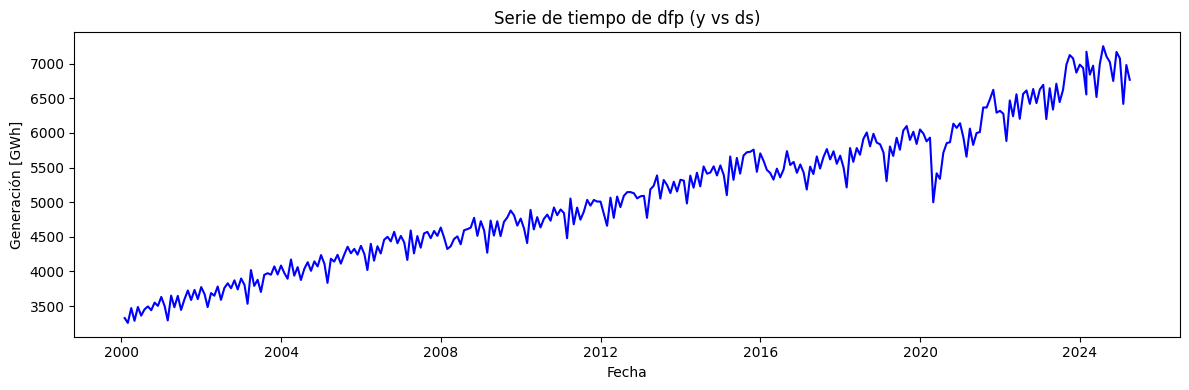

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(dfp["ds"], dfp["y"], color='blue')
plt.title("Serie de tiempo de dfp (y vs ds)")
plt.xlabel("Fecha")
plt.ylabel("Generación [GWh]")
plt.tight_layout()
plt.show()

21:51:01 - cmdstanpy - INFO - Chain [1] start processing
21:51:01 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/python/3.12.1/lib/python3.12/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


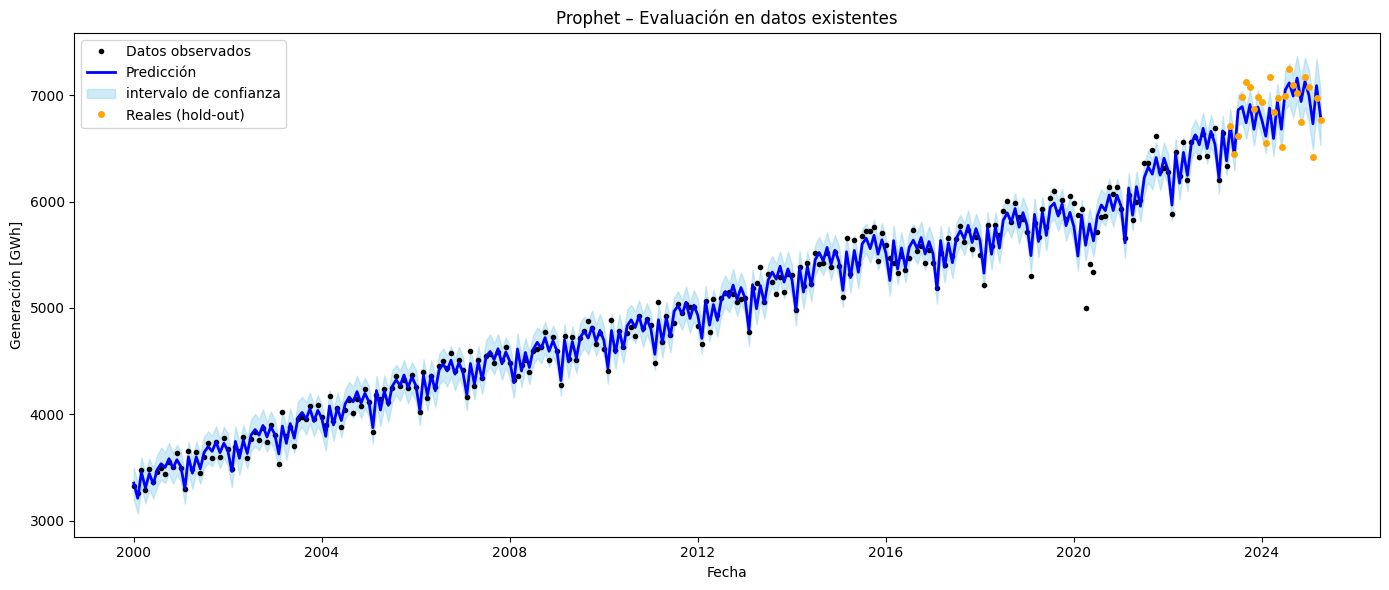

In [14]:
# === Modelo base Prophet (sin MCMC) + gráfico completo estilo base ===
# Si es la primera vez en Colab:
# !pip install -q prophet


# 0) Limpieza y preparación (ds: fecha, y: serie)
dfp = dfp.dropna(subset=['ds','y']).sort_values('ds')
dfp = dfp.groupby('ds', as_index=False)['y'].sum()
dfp['ds'] = pd.to_datetime(dfp['ds'])
dfp['y']  = pd.to_numeric(dfp['y'], errors='coerce')
dfp = dfp.dropna(subset=['y']).reset_index(drop=True)

# Si no detecta frecuencia, forzamos mensual al inicio de mes
if pd.infer_freq(dfp['ds']) is None:
    dfp = (dfp
           .assign(ds=lambda d: d['ds'].dt.to_period('M').dt.to_timestamp(how='start'))
           .groupby('ds', as_index=False)['y'].sum()
           .sort_values('ds')
          )

# 1) Split: últimos 24 meses como test
N_TEST = 24
df_train = dfp.iloc[:-N_TEST].copy()
df_test  = dfp.iloc[-N_TEST:].copy()

# 2) Modelo Prophet (MAP por defecto, sin MCMC)
m = Prophet(
    yearly_seasonality=True,     # mensual con estacionalidad anual
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoint_range=0.95,
    changepoint_prior_scale=0.2,
    interval_width=0.90          # un poco menos conservador que 0.95
)
m.fit(df_train[['ds','y']])

# 3) Pronóstico para toda la serie (train + 24 de test)
future = m.make_future_dataframe(periods=N_TEST, freq='M')
forecast = m.predict(future)

# 4) Gráfico estilo base
plt.figure(figsize=(14,6))

# Observados (train)
plt.plot(df_train['ds'], df_train['y'], 'k.', label='Datos observados')

# Pronóstico central
plt.plot(forecast['ds'], forecast['yhat'], 'b-', label='Predicción', linewidth=2)

# Intervalo de incertidumbre
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='skyblue', alpha=0.4, label='intervalo de confianza')

# Reales (hold-out)
plt.plot(df_test['ds'], df_test['y'],'o', mfc='orange', mec='none', mew=1, ms=5, label='Reales (hold-out)')

plt.title("Prophet – Evaluación en datos existentes")
plt.xlabel("Fecha"); plt.ylabel("Generación [GWh]")
plt.legend()
plt.tight_layout()
plt.show()


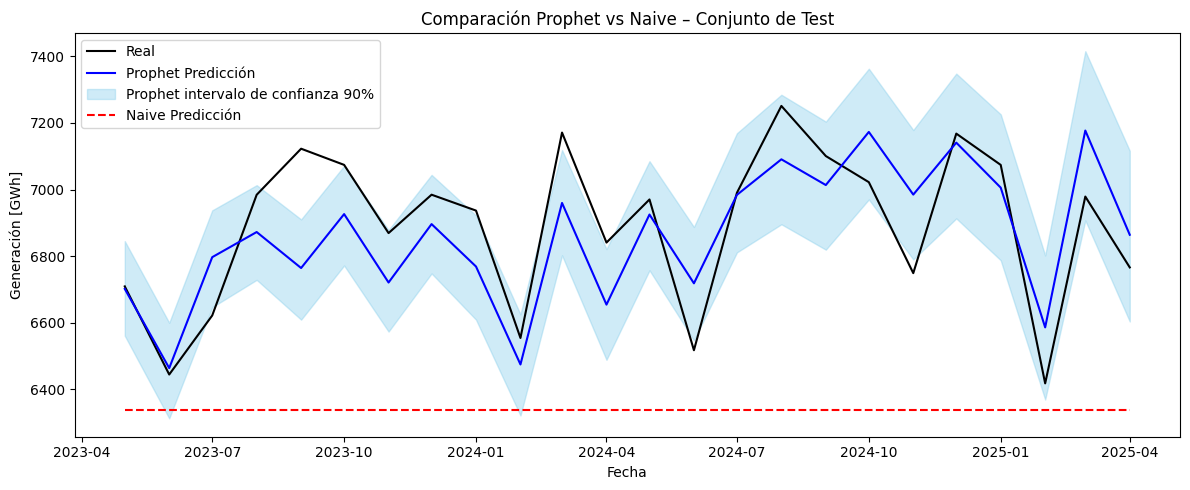

In [15]:

# Predicciones e intervalos en el set de test
fcst_test = m.predict(df_test[['ds']])
ev_test_plot = df_test[['ds','y']].merge(
    fcst_test[['ds','yhat','yhat_lower','yhat_upper']], on='ds', how='left'
)

# Naive: constante = último valor del train
last_train_val = df_train['y'].iloc[-1]
naive_test_pred = np.full(len(df_test), last_train_val)

plt.figure(figsize=(12,5))
plt.plot(ev_test_plot['ds'], ev_test_plot['y'], 'k-', label='Real')
plt.plot(ev_test_plot['ds'], ev_test_plot['yhat'], 'b-', label='Prophet Predicción')
plt.fill_between(ev_test_plot['ds'], ev_test_plot['yhat_lower'], ev_test_plot['yhat_upper'],
                 color='skyblue', alpha=0.4, label='Prophet intervalo de confianza 90%')
plt.plot(ev_test_plot['ds'], naive_test_pred, 'r--', label='Naive Predicción')
plt.title("Comparación Prophet vs Naive – Conjunto de Test")
plt.xlabel("Fecha"); plt.ylabel("Generación [GWh]")
plt.legend(); plt.tight_layout(); plt.show()

In [16]:


# Funciones
def rmse(y, yhat):  return float(np.sqrt(np.mean((y - yhat)**2)))
def mape(y, yhat):  return float(np.mean(np.abs((y - yhat) / y)) * 100)

# --- Predicciones Prophet en train y test ---
fcst_train = m.predict(df_train[['ds']])
fcst_test  = m.predict(df_test[['ds']])

ev_train = df_train[['ds','y']].merge(fcst_train[['ds','yhat']], on='ds', how='left')
ev_test  = df_test[['ds','y']].merge(fcst_test[['ds','yhat']],   on='ds', how='left')

rmse_train = rmse(ev_train['y'].values, ev_train['yhat'].values)
mape_train = mape(ev_train['y'].values, ev_train['yhat'].values)

rmse_test  = rmse(ev_test['y'].values,  ev_test['yhat'].values)
mape_test  = mape(ev_test['y'].values,  ev_test['yhat'].values)

# --- Modelo Naive ---
# Train: predice cada punto como el valor anterior (lag-1)
naive_train_pred = ev_train['y'].shift(1)
rmse_train_naive = rmse(ev_train['y'].iloc[1:].values, naive_train_pred.iloc[1:].values)
mape_train_naive = mape(ev_train['y'].iloc[1:].values, naive_train_pred.iloc[1:].values)

# Test: predice todo como el último valor del train
last_train_val   = df_train['y'].iloc[-1]
naive_test_pred  = np.repeat(last_train_val, len(df_test))
rmse_test_naive  = rmse(ev_test['y'].values, naive_test_pred)
mape_test_naive  = mape(ev_test['y'].values, naive_test_pred)

# --- Comparación ---
print("=== Prophet REGULARIZADO ===")
print(f"RMSE Train: {rmse_train:.2f} | MAPE Train: {mape_train:.2f}%")
print(f"RMSE Test:  {rmse_test:.2f} | MAPE Test:  {mape_test:.2f}%")

print("\n=== Naive ===")
print(f"RMSE Train: {rmse_train_naive:.2f} | MAPE Train: {mape_train_naive:.2f}%")
print(f"RMSE Test:  {rmse_test_naive:.2f} | MAPE Test:  {mape_test_naive:.2f}%")



=== Prophet REGULARIZADO ===
RMSE Train: 88.43 | MAPE Train: 1.20%
RMSE Test:  154.68 | MAPE Test:  1.90%

=== Naive ===
RMSE Train: 216.76 | MAPE Train: 3.64%
RMSE Test:  599.78 | MAPE Test:  7.90%


In [17]:

# === Predicciones del modelo ACTUAL (Prophet base + dummy COVID si existe) y Naive en el mismo hold-out ===
# Armar columnas necesarias para predecir con el modelo actual `m`
reg_cols = [c for c in ['covid_dummy','postcovid_dummy','ramp_postcovid'] if c in df_test.columns]
fcst_test = m.predict(df_test[['ds'] + reg_cols])

# Emparejar con observados
ev_test_cur = df_test[['ds','y']].merge(fcst_test[['ds','yhat']], on='ds', how='left')
y_test = ev_test_cur['y'].to_numpy(dtype=float)
yhat_prophet = ev_test_cur['yhat'].to_numpy(dtype=float)

# Naive: todos los puntos del test = último valor del train
last_train_val = float(df_train['y'].iloc[-1])
yhat_naive = np.full_like(y_test, fill_value=last_train_val, dtype=float)

# === Diebold–Mariano (con Newey–West y corrección HLN) ===
def diebold_mariano(y_true, yhat_1, yhat_2, h=1, loss='MSE'):
    """
    Compara modelo 1 vs modelo 2 en el MISMO hold-out.
    loss: 'MSE' (cuadrática) o 'MAE' (absoluta)
    h: horizonte de pronóstico; para multi-step overlapped usar h>1 (NW con L=h-1)
    """
    y_true = np.asarray(y_true, float)
    yhat_1 = np.asarray(yhat_1, float)
    yhat_2 = np.asarray(yhat_2, float)

    if loss.upper() == 'MSE':
        d = (y_true - yhat_1)**2 - (y_true - yhat_2)**2
    elif loss.upper() == 'MAE':
        d = np.abs(y_true - yhat_1) - np.abs(y_true - yhat_2)
    else:
        raise ValueError("loss debe ser 'MSE' o 'MAE'")

    T = d.size
    d_bar = d.mean()

    # Varianza HAC Newey–West (kernel Bartlett)
    if h > 1:
        L = max(1, h - 1)
    else:
        L = int(np.floor(T**(1/3)))  # regla simple cuando h=1
    d_c = d - d_bar
    gamma0 = np.dot(d_c, d_c) / T
    s = gamma0
    for k in range(1, L + 1):
        gamma_k = np.dot(d_c[k:], d_c[:-k]) / T
        w = 1.0 - k / (L + 1.0)
        s += 2.0 * w * gamma_k
    var_dbar = s / T
    dm = d_bar / (np.sqrt(var_dbar) + 1e-12)

    # Corrección Harvey–Leybourne–Newbold y p-valor
    c = np.sqrt((T + 1 - 2*h + (h*(h-1))/T) / T) if h > 1 else 1.0
    dm_hln = dm * c
    pval = 2 * (1 - student_t.cdf(np.abs(dm_hln), df=T - 1))
    return dm_hln, pval, d_bar, var_dbar

# Ejecutar DM para MSE y MAE
dm_mse_stat, dm_mse_p, dbar_mse, _ = diebold_mariano(y_test, yhat_prophet, yhat_naive, h=1, loss='MSE')
dm_mae_stat, dm_mae_p, dbar_mae, _ = diebold_mariano(y_test, yhat_prophet, yhat_naive, h=1, loss='MAE')

print("=== Diebold–Mariano: Prophet (modelo 1) vs Naive (modelo 2) ===")
print(f"MSE:  DM={dm_mse_stat:.3f}  p-value={dm_mse_p:.4f}  d_bar={dbar_mse:.3f}  "
      f"({'Prophet mejor' if dbar_mse<0 else 'Naive mejor' if dbar_mse>0 else 'Empate'})")
print(f"MAE:  DM={dm_mae_stat:.3f}  p-value={dm_mae_p:.4f}  d_bar={dbar_mae:.3f}  "
      f"({'Prophet mejor' if dbar_mae<0 else 'Naive mejor' if dbar_mae>0 else 'Empate'})")


=== Diebold–Mariano: Prophet (modelo 1) vs Naive (modelo 2) ===
MSE:  DM=-7.210  p-value=0.0000  d_bar=-335806.889  (Prophet mejor)
MAE:  DM=-9.720  p-value=0.0000  d_bar=-420.492  (Prophet mejor)


21:51:24 - cmdstanpy - INFO - Chain [1] start processing
21:51:24 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/python/3.12.1/lib/python3.12/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


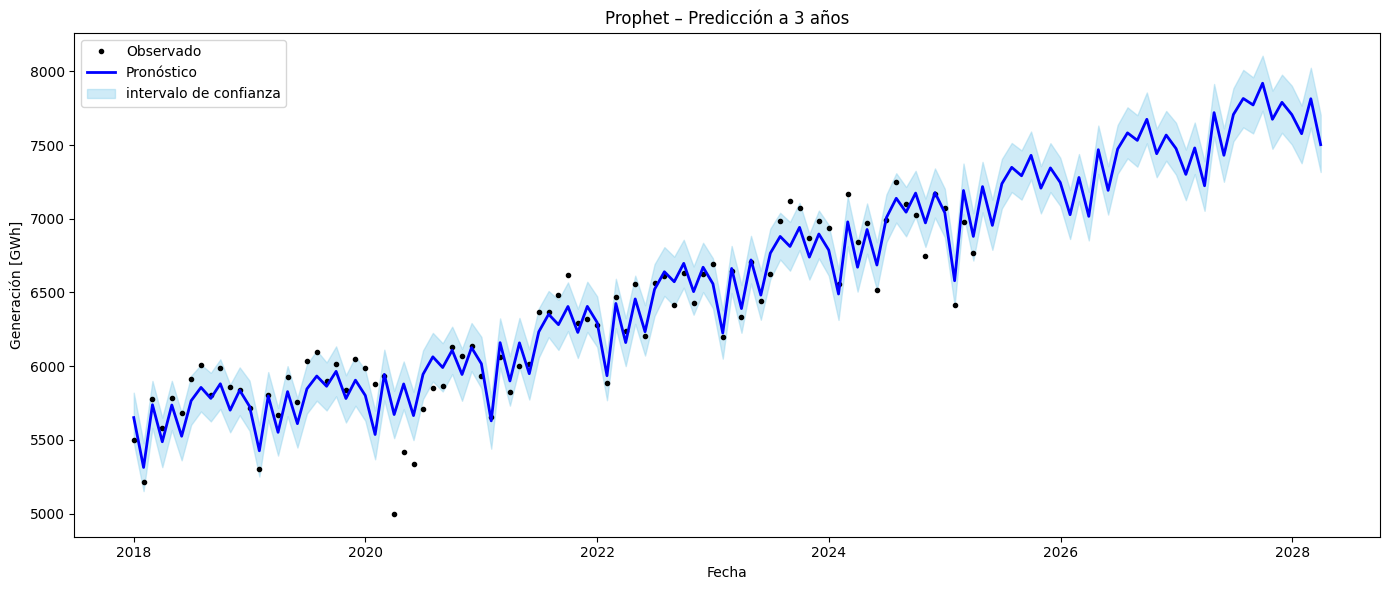

In [18]:
# -------- 0) Preparación de datos --------
dfp = dfp.dropna(subset=['ds','y']).sort_values('ds')
dfp = dfp.groupby('ds', as_index=False)['y'].sum()
dfp['ds'] = pd.to_datetime(dfp['ds'])
dfp['y']  = pd.to_numeric(dfp['y'], errors='coerce')
dfp = dfp.dropna(subset=['y']).reset_index(drop=True)

if pd.infer_freq(dfp['ds']) is None:
    dfp = (dfp.assign(ds=lambda d: d['ds'].dt.to_period('M').dt.to_timestamp(how='start'))
               .groupby('ds', as_index=False)['y'].sum())

# -------- 1) Cap/Floor si logistic --------
use_logistic = 'cap' in dfp.columns or 'floor' in dfp.columns
if use_logistic:
    if 'cap' not in dfp.columns:
        cap_value = dfp['y'].max() * 1.15
        dfp['cap'] = cap_value
    if 'floor' not in dfp.columns:
        dfp['floor'] = 0.0

# -------- 2) Regresores --------
candidate_regs = ['covid_dummy', 'postcovid_dummy', 'ramp_postcovid']
reg_cols = [c for c in candidate_regs if c in dfp.columns]

# -------- 3) Modelo REGULARIZADO --------
m_reg = Prophet(
    growth=("logistic" if use_logistic else "linear"),
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.10,
    changepoint_range=0.90,
    n_changepoints=40,
    interval_width=0.90
)
m_reg.add_seasonality(name='yearly', period=365.25, fourier_order=10)

for c in reg_cols:
    mode = "additive" if "covid" in c else "multiplicative"
    m_reg.add_regressor(c, prior_scale=5.0, mode=mode)

fit_cols = ['ds','y'] + (['cap','floor'] if use_logistic else []) + reg_cols
m_reg.fit(dfp[fit_cols])

# -------- 4) Predicción a 3 años --------
future = m_reg.make_future_dataframe(periods=36, freq='M')
if use_logistic:
    future['cap'] = dfp['cap'].iloc[-1]
    future['floor'] = dfp['floor'].iloc[-1]

for c in reg_cols:
    if c in dfp.columns:
        if c in ['covid_dummy','postcovid_dummy']:
            future[c] = ((future['ds'] >= dfp['ds'].min())).astype(int)
        elif c == 'ramp_postcovid':
            postcovid_ini = pd.to_datetime("2021-04-01")
            span_f = (future['ds'].max() - postcovid_ini).days
            future['ramp_postcovid'] = 0.0
            mask_f = future['ds'] >= postcovid_ini
            future.loc[mask_f, 'ramp_postcovid'] = (future.loc[mask_f, 'ds'] - postcovid_ini).dt.days / max(span_f,1)

forecast = m_reg.predict(future)

# Definir fecha de inicio para graficar
zoom_start = pd.to_datetime("2018-01-01")

plt.figure(figsize=(14,6))

# Observados desde 2018
mask_obs = dfp['ds'] >= zoom_start
plt.plot(dfp.loc[mask_obs, 'ds'], dfp.loc[mask_obs, 'y'], 'k.', label='Observado')

# Forecast desde 2018
mask_fcst = forecast['ds'] >= zoom_start
plt.plot(forecast.loc[mask_fcst, 'ds'], forecast.loc[mask_fcst, 'yhat'], 'b-', label='Pronóstico', linewidth=2)

# Intervalo de incertidumbre
plt.fill_between(forecast.loc[mask_fcst, 'ds'],
                 forecast.loc[mask_fcst, 'yhat_lower'],
                 forecast.loc[mask_fcst, 'yhat_upper'],
                 color='skyblue', alpha=0.4, label='intervalo de confianza')

plt.title("Prophet – Predicción a 3 años")
plt.xlabel("Fecha"); plt.ylabel("Generación [GWh]")
plt.legend(); plt.tight_layout(); plt.show()